In [115]:
%load_ext google.cloud.bigquery
%matplotlib inline

import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import seaborn as sns
sns.set_theme()

pd.set_option("display.expand_frame_repr", False)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_colwidth', None)

sats = 100000000

def millions(x, pos):
    'The two args are the value and tick position'
    return '%1.1fM' % (x * 1e-6)

formatter = FuncFormatter(millions)

The google.cloud.bigquery extension is already loaded. To reload it, use:
  %reload_ext google.cloud.bigquery


In [96]:
%%bigquery blocks
WITH fees AS (
SELECT block_number
     , SUM(fee) / 100000000 AS block_fees
  FROM `bigquery-public-data.crypto_bitcoin.transactions`
 GROUP BY 1
), median AS (
SELECT DISTINCT bits
     , median_unused_block_space
  FROM (
  SELECT bits
       , PERCENTILE_CONT(4000000 - weight, 0.5) OVER(PARTITION BY bits) AS median_unused_block_space
  FROM `bigquery-public-data.crypto_bitcoin.blocks`
)), mean AS (
SELECT bits
     , MIN(timestamp) AS difficulty_period
     , AVG(4000000 - weight) AS avg_unused_block_space
     , SUM(block_fees) AS block_fees
  FROM `bigquery-public-data.crypto_bitcoin.blocks` b JOIN fees f ON b.number = f.block_number
 GROUP BY 1
) SELECT mean.*, median.median_unused_block_space FROM median JOIN mean ON median.bits = mean.bits

Downloading: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:01<00:00, 225.37rows/s]


In [122]:
blocks_dt = blocks.set_index(
    pd.DatetimeIndex(pd.to_datetime(blocks['difficulty_period']))
).drop('difficulty_period', axis=1).sort_index()
blocks_dt = blocks_dt.astype({'block_fees': float})

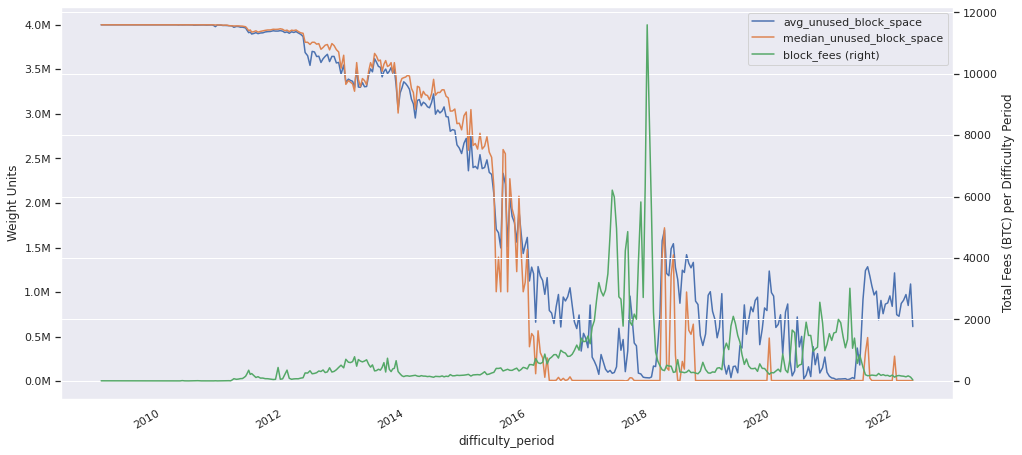

In [113]:
ax = blocks_dt[['avg_unused_block_space', 'median_unused_block_space']].plot(figsize=(16,8), ylabel='Weight Units')
ax.yaxis.set_major_formatter(formatter)
blocks_dt['block_fees'].plot(secondary_y=True, ax=ax, legend=True)
plt.ylabel('Total Fees (BTC) per Difficulty Period');

# Measuring Unused Block Space

Graph below shows mean (average) unused block space per difficulty period, median unused block space per difficulty period and total fees per difficulty period, plotted on the secondary (right) axis. Median is included because it provides a slightly different but interesting view of a difficulty period. Median tells what value of unused space 50% of the blocks in a diffuculty period were below. A few observations:

* From 2016 - 2018, the median is consequetively ~0 which means 50% of all blocks in each difficulty period were full. This is correlated with a run up in fees, peaking with a difficulty period where 12000 BTC in fees was collected in total
* 2018 onwards, we see fees inversely correlated with unused blockspace, which is expected (unused space goes up, total fees collected goes down)

For a more granular view, below is the same graph but 2016 and onwards:

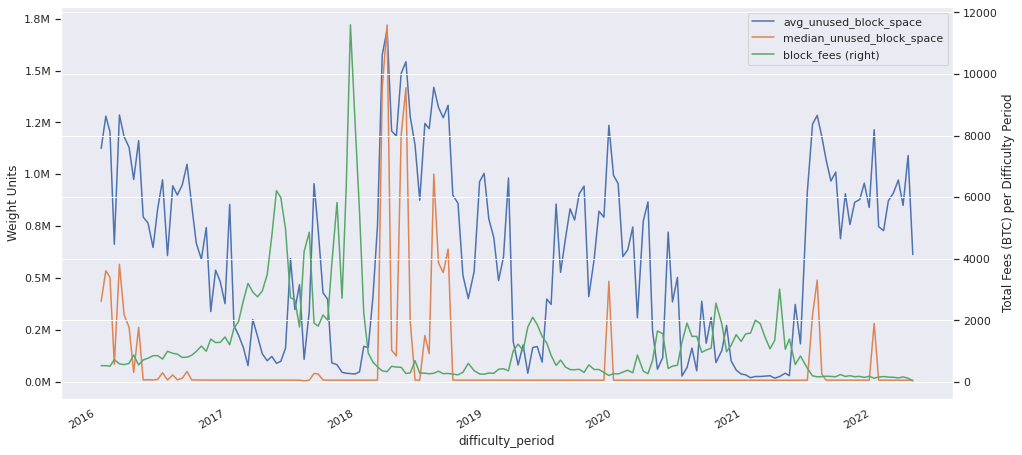

In [125]:
blocks_2016 = blocks_dt["2016":]
ax = blocks_2016[['avg_unused_block_space', 'median_unused_block_space']].plot(figsize=(16,8), ylabel='Weight Units')
ax.yaxis.set_major_formatter(formatter)
blocks_2016['block_fees'].plot(secondary_y=True, ax=ax, legend=True)
plt.ylabel('Total Fees (BTC) per Difficulty Period');